#E-16 Movie_recommendation  
----

In [1]:
import tensorflow
import datetime as dt
from pathlib import Path
import pandas as pd
import os
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = '/content/drive/MyDrive/colab/yoochoose'
train_path = data_path +'/ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [6]:
user_length.min(), user_length.max()

(20, 2314)

In [7]:
user_length[2314]

35

In [8]:
data[data['UserId']==35]

,UserId,ItemId,Rating,Time
5006,35,1096,3,978100295
4830,35,1835,4,978100391
4873,35,902,5,978100391
4925,35,863,2,978100391
4832,35,155,3,978100415
...,...,...,...,...
4907,35,3703,4,978104742
4965,35,2947,3,978104757
4892,35,910,4,978104931
4948,35,3088,5,978104931


In [9]:
print(user_length.quantile(0.999))
print(user_length.quantile(1))

1343.181000000005
2314.0


In [10]:
long_user = user_length[user_length==2314].index[0]
data[data['UserId']==long_user].value_counts()

UserId  ItemId  Rating  Time     
4169    2       3       976588802    1
        2736    3       971580991    1
        2651    3       967165120    1
        2653    4       965333392    1
        2654    3       967165120    1
                                    ..
        1307    5       968798452    1
        1312    3       975804513    1
        1317    3       973310574    1
        1320    3       975805470    1
        3952    4       985826081    1
Length: 2314, dtype: int64

In [11]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

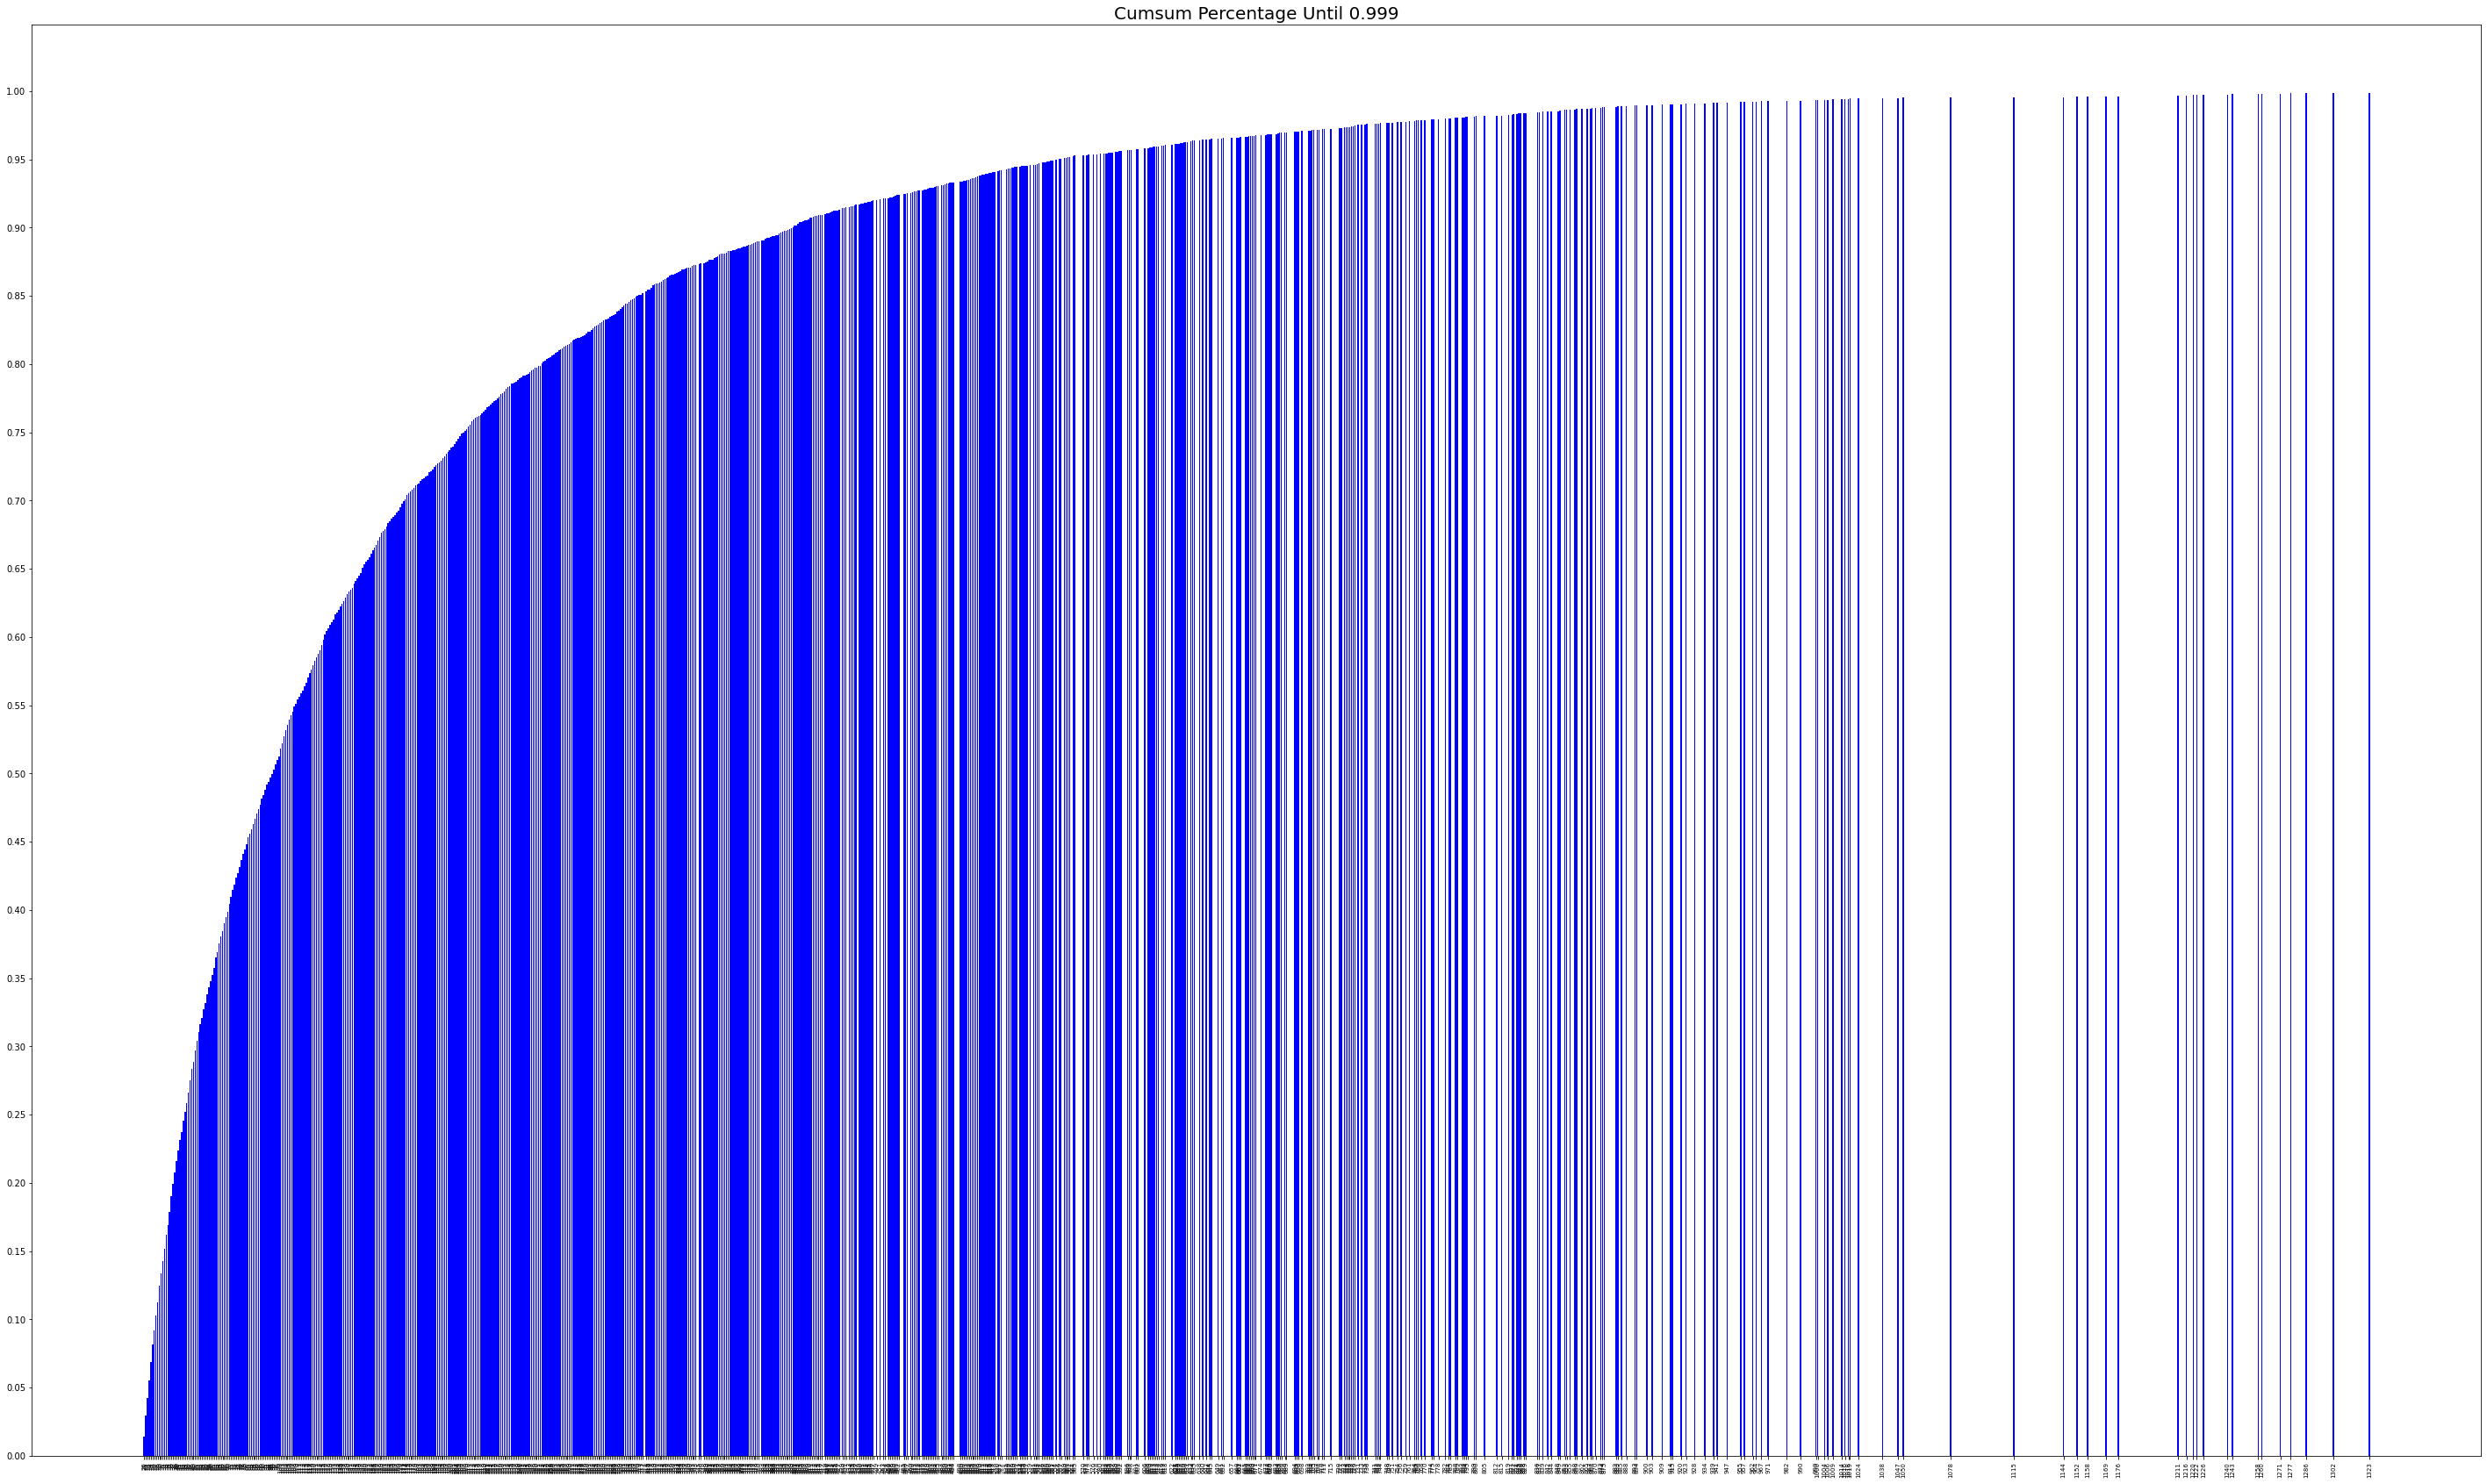

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 30))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index, rotation=90, fontsize=7)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [13]:
user_length.quantile(0.99)

906.659999999998

In [14]:
Rating_counts = data['Rating'].value_counts()
Rating_counts

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64

In [15]:
drop_index = user_length[user_length>906].index
data.drop(index=drop_index, inplace=True)

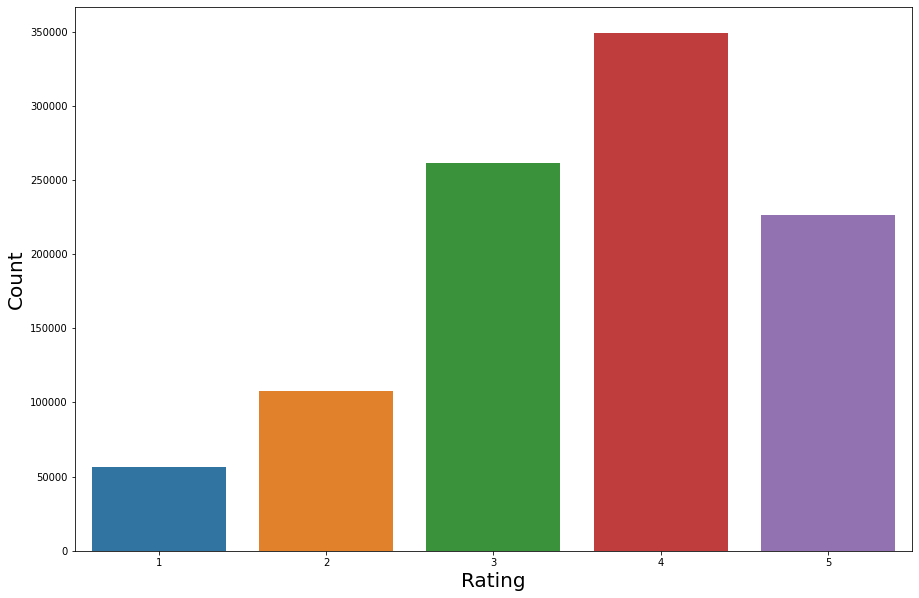

In [16]:
f,ax = plt.subplots(figsize = (15,10))
ax = sns.barplot(x=Rating_counts.index, y=Rating_counts.values, data=data)
plt.xlabel("Rating",fontsize = 20)
plt.ylabel("Count",fontsize = 20)
plt.show()

In [17]:
data = data[data['Rating']>=4]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
36,1,1836,5,978300172
...,...,...,...,...
1000119,6040,3671,4,997454367
999923,6040,232,5,997454398
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464


In [18]:
data.shape

(575249, 4)

In [19]:
Rating_counts_remove = data['Rating'].value_counts()
Rating_counts_remove

4    348949
5    226300
Name: Rating, dtype: int64

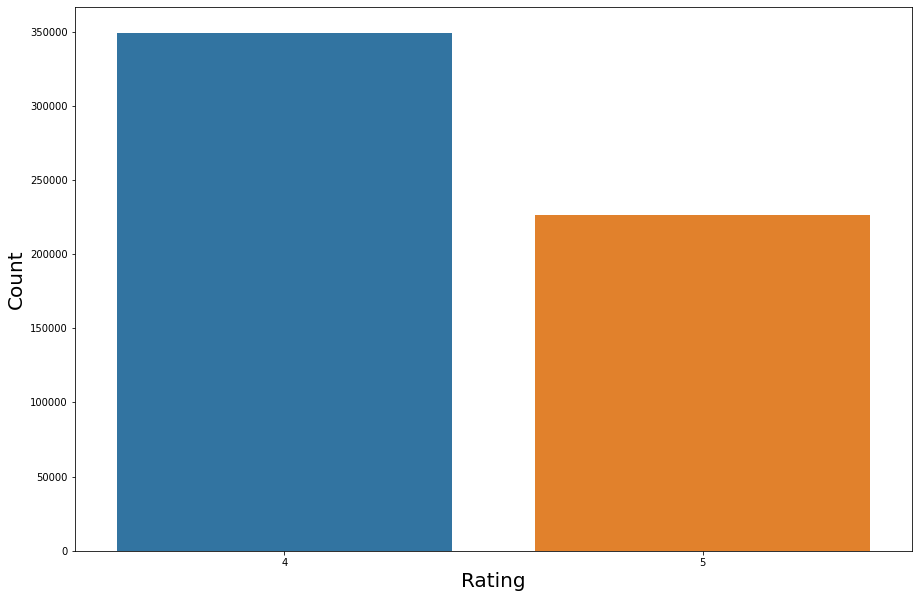

In [20]:
f,ax = plt.subplots(figsize = (15,10))
ax = sns.barplot(x=Rating_counts_remove.index, y=Rating_counts_remove.values, data=data)
plt.xlabel("Rating",fontsize = 20)
plt.ylabel("Count",fontsize = 20)
plt.show()

In [21]:
from datetime import datetime

def timestamp_convert(series_time):
    temp = series_time.copy()
    for i, v in enumerate(series_time):
        temp.iloc[i] = datetime.fromtimestamp(v)
    return temp

data['Time'] = timestamp_convert(data['Time'])
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
36,1,1836,5,2000-12-31 22:02:52


In [22]:
data.sort_values(['UserId', 'Time'], inplace= True)

data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
36,1,1836,5,2000-12-31 22:02:52
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


In [23]:
#UesrId, ItemId, Time 개수 확인
data['UserId'].nunique(), data['ItemId'].nunique(), data['Time'].nunique()

(6038, 3533, 323691)

In [24]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [25]:
data[data['UserId'] == 36].head(), data[data['UserId'] == 36].tail()

(      UserId  ItemId  Rating                 Time
 5130      36    2671       5  2000-12-29 03:35:55
 5163      36    2250       4  2000-12-29 03:35:55
 5313      36    2023       4  2000-12-29 03:35:55
 5088      36    1270       5  2000-12-29 03:36:22
 5250      36    3301       4  2000-12-29 03:36:47,
       UserId  ItemId  Rating                 Time
 5104      36     247       4  2002-12-22 08:17:48
 5062      36    1266       5  2002-12-22 08:18:29
 5076      36     595       4  2002-12-22 08:18:29
 5126      36    1295       4  2002-12-22 08:18:29
 5180      36    3639       4  2002-12-22 08:18:45)

In [26]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [27]:
data = cleanse_recursive(data, shortest=3, least_click=10)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
36,1,1836,5,2000-12-31 22:02:52
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


In [28]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [29]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [30]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [31]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 470628
	 Sessions: 5570
	 Items: 2811
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-04 22:46:11

* valid Set Stats Info
	 Events: 29530
	 Sessions: 152
	 Items: 2497
	 First Time : 2000-04-30 06:38:59
	 Last Time : 2002-09-01 00:14:13

* test Set Stats Info
	 Events: 72008
	 Sessions: 313
	 Items: 2726
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



In [32]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [33]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [34]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
36,1,1836,5,2000-12-31 22:02:52,4
3,1,3408,4,2000-12-31 22:04:35,5
7,1,2804,5,2000-12-31 22:11:59,6
47,1,1207,4,2000-12-31 22:11:59,7
0,1,1193,5,2000-12-31 22:12:40,8
44,1,260,4,2000-12-31 22:12:40,9


In [35]:
tr_dataset.click_offsets

array([     0,     45,    118, ..., 470326, 470416, 470628], dtype=int32)

In [36]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5567, 5568, 5569])

In [83]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters]+1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=0):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [84]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)

In [85]:
iter_ex = iter(tr_data_loader)

In [86]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 45 52 22]
Label Item Idx are :       [  1  46 112  56]
Previous Masked Input Idx are []


In [87]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [88]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [89]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [90]:
model = create_model(args)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(128, 1, 2811)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               429450    
                              (128, 50)]                         
                                                                 
 dropout_4 (Dropout)         (128, 50)                 0         
                                                                 
 dense_4 (Dense)             (128, 2811)               143361    
                                                                 
Total params: 572,811
Trainable params: 572,811
Non-trainable params: 0
_________________________________________________________________


In [91]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    
    history = {'val_recall':[], 'val_mrr':[], 'train_loss':[], 'Epoch':[]} # 시각화를 위한 history를 생성함
    
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.
        
        history['val_recall'].append(float(val_recall))
        history['val_mrr'].append(float(val_mrr))
        history['train_loss'].append(result[0])
        history['Epoch'].append(epoch)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
        
    return history


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [92]:
training = train_model(model, args)

Evaluation:  32%|███▏      | 73/229 [01:05<02:20,  1.11it/s]


	 - Recall@20 epoch 1: 0.196597
	 - MRR@20    epoch 1: 0.047665



Evaluation:  32%|███▏      | 73/229 [01:02<02:14,  1.16it/s]


	 - Recall@20 epoch 2: 0.255886
	 - MRR@20    epoch 2: 0.067830



Evaluation:  32%|███▏      | 73/229 [01:01<02:11,  1.18it/s]

	 - Recall@20 epoch 3: 0.287136
	 - MRR@20    epoch 3: 0.079702



In [93]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  69%|██████▊   | 384/560 [05:32<02:32,  1.15it/s]

	 - Recall@20: 0.241272
	 - MRR@20: 0.063067



In [94]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.2, lr=0.001, epochs=3, k=20)
train_model(model, args)

Evaluation:  32%|███▏      | 73/229 [01:00<02:09,  1.20it/s]


	 - Recall@20 epoch 1: 0.301049
	 - MRR@20    epoch 1: 0.086382



Evaluation:  32%|███▏      | 73/229 [01:00<02:08,  1.21it/s]


	 - Recall@20 epoch 2: 0.307470
	 - MRR@20    epoch 2: 0.089944



Evaluation:  32%|███▏      | 73/229 [01:00<02:08,  1.21it/s]

	 - Recall@20 epoch 3: 0.314961
	 - MRR@20    epoch 3: 0.093103



{'Epoch': [1, 2, 3],
 'train_loss': [5.536304473876953, 5.420583724975586, 5.448408603668213],
 'val_mrr': [0.08638197495278511, 0.08994395707709776, 0.09310287182793653],
 'val_recall': [0.301048801369863, 0.3074700342465753, 0.3149614726027397]}

In [95]:
test_model(model, args, test)

Evaluation:  69%|██████▊   | 384/560 [05:25<02:29,  1.18it/s]

	 - Recall@20: 0.264628
	 - MRR@20: 0.074132



#### 회고  
----  
실제 영화추천 시스템을 이런수준으로 만든다면 아마 그 회사는 망하지 않을까 싶다. train과정에서 IndexError가 떴는데 처음에는 너무 당황해서 어떻게 해야할지 몰랐지만, 검색을 통해 예시를 보고 곰곰히 생각해보니 var의 shape보다 batch의 shape가 커서 문제가 됐었던 것 같다. 그래서 batch size를 var의 size보다 작게 변경해주었더니 train이 됐다. 문제해결을 해서 다행이였지만, 만일 수행하지 못했다면 정말 피눈물을 흘렸을 것 같다. 그리고 UserId와 Time으로 SessionId를 만들어내야하는 것 같은데, 그 과정이 너무 너 알아서 해봐 하는 느낌이라 감을 잡을 수 없었다. 해내지 못한 것은 내 실력문제겠거니 하고 더 많은 공부가 필요하다는 것을 이렇게 알아간다. Rating은 아무래도 4점 이상이여야 추천해줄만한 영화이지 않나 싶은 생각이 들어서 3점 이하를 모두 날려버렸는데 어쩌면 itemid별로 총 합을 낸 다음 평균을 내서 추천해줄만한 영화인지 아닌지 검토해보는게 더 맞지 않을까라는 생각을 다 해놓고 나서 하게 되었다. 아니면 1점만 제외하고 해보는 것도 좋았을듯?? (1점이라는 점수는 보통 부여하기 힘든 점수라 악의를 가진 사람들이나, 정말 영화에 대한 실망이 큰 경우에만 나올거라 예상해서 제외 시키는 것도 괜찮을 듯) Recall값은 아주 바닥을 치고 있어서 눈뜨고 보기가 힘든 수준인 듯하다. 이 노드에서 진정으로 학생에게 알려주고 싶은 것이 무엇인지 잘 모르겠지만 어쨌든 완료했다!